In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month   

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [19]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize your numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit your instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.fit_transform(x_test) #Transform your test data instance features_test
x_val_scaled = ct.fit_transform(x_val)

## Model Creation

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(33)
tf.random.set_seed(33)

model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [21]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [22]:
np.random.seed(33)
tf.random.set_seed(33)

history = model.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10

17005/17005 [==============================] - 19s 1ms/step - loss: 0.0740 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0718 - val_binary_accuracy: 0.9846 - val_recall: 5.5648e-04
Epoch 2/10
17005/17005 [==============================] - 17s 1ms/step - loss: 0.0711 - binary_accuracy: 0.9846 - recall: 0.0027 - val_loss: 0.0711 - val_binary_accuracy: 0.9845 - val_recall: 0.0050
Epoch 3/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0701 - binary_accuracy: 0.9846 - recall: 0.0072 - val_loss: 0.0700 - val_binary_accuracy: 0.9846 - val_recall: 0.0056
Epoch 4/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0695 - binary_accuracy: 0.9845 - recall: 0.0063 - val_loss: 0.0703 - val_binary_accuracy: 0.9846 - val_recall: 0.0089
Epoch 5/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0691 - binary_accuracy: 0.9846 - recall: 0.0083 - val_loss: 0.0702 - val_binary_accuracy: 0.9844 - val_recall: 0.0

In [23]:
accuracy = model.evaluate(x_test_scaled, y_test)
print("Test Accuracy:", accuracy)

3644/3644 [==============================] - 3s 717us/step - loss: 0.0698 - binary_accuracy: 0.9845 - recall: 0.0067
Test Accuracy: [0.06978819519281387, 0.98451167345047, 0.006677796132862568]


In [24]:
# Detailed report of model to look at all metrics
from sklearn.metrics import classification_report

y_pred = model.predict(x_test_scaled)
y_pred = (y_pred >= 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

3644/3644 [==============================] - 2s 586us/step
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    114807
        True       0.36      0.01      0.01      1797

    accuracy                           0.98    116604
   macro avg       0.67      0.50      0.50    116604
weighted avg       0.98      0.98      0.98    116604



In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Confusion Matrix
threshold = 0.5 
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)


# Print metrics
print("AUC:", auc)
print("Confusion Matrix:")
print(cm)

AUC: 0.5032474403256693
Confusion Matrix:
[[114786     21]
 [  1785     12]]


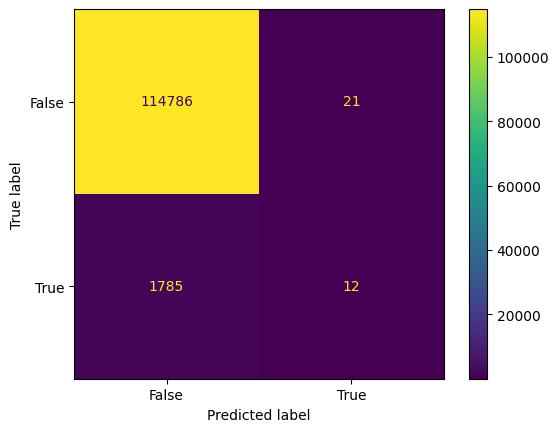

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

## Model Creation with SMOTE

In [27]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [28]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize your numerical features

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit your instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train_resampled)
x_test_scaled = ct.fit_transform(x_test) #Transform your test data instance features_test
x_val_scaled = ct.fit_transform(x_val)

In [29]:
np.random.seed(33)
tf.random.set_seed(33)

model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [30]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [31]:
np.random.seed(33)
tf.random.set_seed(33)

history = model.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 33s 972us/step - loss: 0.1122 - binary_accuracy: 0.9586 - recall_1: 0.9386 - val_loss: 0.5925 - val_binary_accuracy: 0.7442 - val_recall_1: 0.5337
Epoch 2/10
33486/33486 [==============================] - 33s 990us/step - loss: 0.0808 - binary_accuracy: 0.9722 - recall_1: 0.9557 - val_loss: 0.4728 - val_binary_accuracy: 0.8022 - val_recall_1: 0.4674
Epoch 3/10
33486/33486 [==============================] - 33s 975us/step - loss: 0.0739 - binary_accuracy: 0.9751 - recall_1: 0.9600 - val_loss: 0.9014 - val_binary_accuracy: 0.6778 - val_recall_1: 0.5982
Epoch 4/10
33486/33486 [==============================] - 33s 986us/step - loss: 0.0700 - binary_accuracy: 0.9768 - recall_1: 0.9624 - val_loss: 1.2394 - val_binary_accuracy: 0.5726 - val_recall_1: 0.6489
Epoch 5/10
33486/33486 [==============================] - 32s 966us/step - loss: 0.0674 - binary_accuracy: 0.9779 - recall_1: 0.9643 - val_loss: 0.7991 - val_binary_accuracy: 0.698

In [32]:
accuracy = model.evaluate(x_test_scaled, y_test)
print("Test Accuracy:", accuracy)

3644/3644 [==============================] - 3s 767us/step - loss: 1.6833 - binary_accuracy: 0.4831 - recall_1: 0.7429
Test Accuracy: [1.6832736730575562, 0.4830966293811798, 0.7429048418998718]


In [33]:
y_pred = model.predict(x_test_scaled)
y_pred = (y_pred >= 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

3644/3644 [==============================] - 2s 622us/step
              precision    recall  f1-score   support

       False       0.99      0.48      0.65    114807
        True       0.02      0.74      0.04      1797

    accuracy                           0.48    116604
   macro avg       0.51      0.61      0.34    116604
weighted avg       0.98      0.48      0.64    116604



In [34]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Confusion Matrix
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

# Print metrics
print("AUC:", auc)
print("Confusion Matrix:")
print(cm)

AUC: 0.6109674328519957
Confusion Matrix:
[[54996 59811]
 [  462  1335]]


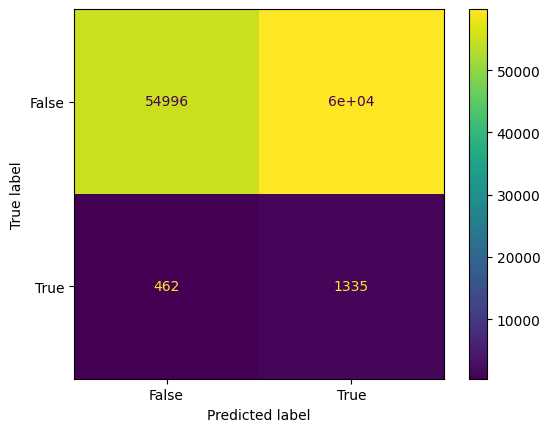

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

## Model 3
Using precision as a metric and SMOTE since it improved True positive rate

In [36]:
np.random.seed(33)
tf.random.set_seed(33)

model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [37]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [38]:
np.random.seed(33)
tf.random.set_seed(33)

history = model.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 35s 1ms/step - loss: 0.1129 - binary_accuracy: 0.9583 - recall_2: 0.9388 - precision: 0.9768 - val_loss: 0.4974 - val_binary_accuracy: 0.7827 - val_recall_2: 0.4680 - val_precision: 0.0333
Epoch 2/10
33486/33486 [==============================] - 33s 983us/step - loss: 0.0796 - binary_accuracy: 0.9729 - recall_2: 0.9570 - precision: 0.9885 - val_loss: 0.7104 - val_binary_accuracy: 0.7204 - val_recall_2: 0.5793 - val_precision: 0.0317
Epoch 3/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0732 - binary_accuracy: 0.9757 - recall_2: 0.9609 - precision: 0.9901 - val_loss: 0.8920 - val_binary_accuracy: 0.6617 - val_recall_2: 0.6405 - val_precision: 0.0288
Epoch 4/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0691 - binary_accuracy: 0.9771 - recall_2: 0.9633 - precision: 0.9908 - val_loss: 0.8460 - val_binary_accuracy: 0.6878 - val_recall_2: 0.5821 - val_precision: 0.0285
Epoch 5/10

In [39]:
accuracy = model.evaluate(x_test_scaled, y_test)
print("Test Accuracy:", accuracy)

3644/3644 [==============================] - 3s 737us/step - loss: 1.6631 - binary_accuracy: 0.4933 - recall_2: 0.7535 - precision: 0.0226
Test Accuracy: [1.663106918334961, 0.4933278560638428, 0.7534779906272888, 0.02257005125284195]


In [40]:
# Detailed report of model to look at all metrics

y_pred = model.predict(x_test_scaled)
y_pred = (y_pred >= 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

3644/3644 [==============================] - 2s 602us/step
              precision    recall  f1-score   support

       False       0.99      0.49      0.66    114807
        True       0.02      0.75      0.04      1797

    accuracy                           0.49    116604
   macro avg       0.51      0.62      0.35    116604
weighted avg       0.98      0.49      0.65    116604



In [41]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Confusion Matrix
threshold = 0.5 
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

# Print metrics
print("AUC:", auc)
print("Confusion Matrix:")
print(cm)

AUC: 0.6213669502652146
Confusion Matrix:
[[56170 58637]
 [  443  1354]]


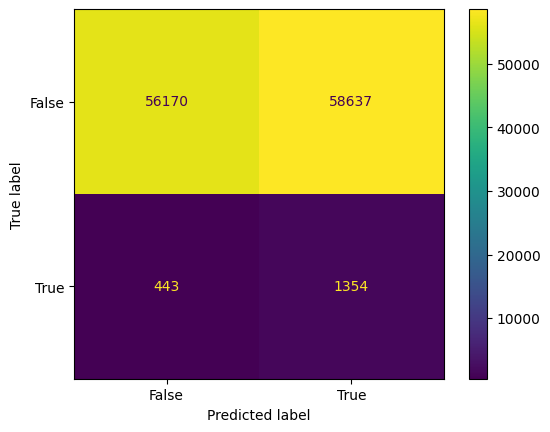

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

## Model 4
Model architecture changes.  
With SMOTE  
Adding two more hidden layers.  
Adding dropout layers  
Adding regularization to hidden layers.

In [43]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

np.random.seed(33)
tf.random.set_seed(33)

model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1), input_shape=(x_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [44]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [45]:
np.random.seed(33)
tf.random.set_seed(33)

history = model.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 51s 1ms/step - loss: 0.7398 - binary_accuracy: 0.4994 - recall_3: 0.5003 - precision_1: 0.4994 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 51s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5265 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 52s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 52s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

In [46]:
accuracy = model.evaluate(x_test_scaled, y_test)
print("Test Accuracy:", accuracy)

3644/3644 [==============================] - 3s 835us/step - loss: 0.6855 - binary_accuracy: 0.9846 - recall_3: 0.0000e+00 - precision_1: 0.0000e+00
Test Accuracy: [0.6855388879776001, 0.9845888614654541, 0.0, 0.0]


In [47]:
# Detailed report of model to look at all metrics

y_pred = model.predict(x_test_scaled)
y_pred = (y_pred >= 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

3644/3644 [==============================] - 2s 646us/step
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    114807
        True       0.00      0.00      0.00      1797

    accuracy                           0.98    116604
   macro avg       0.49      0.50      0.50    116604
weighted avg       0.97      0.98      0.98    116604



c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [48]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Confusion Matrix
threshold = 0.5 
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

# Print metrics
print("AUC:", auc)
print("Confusion Matrix:")
print(cm)

AUC: 0.5
Confusion Matrix:
[[114807      0]
 [  1797      0]]


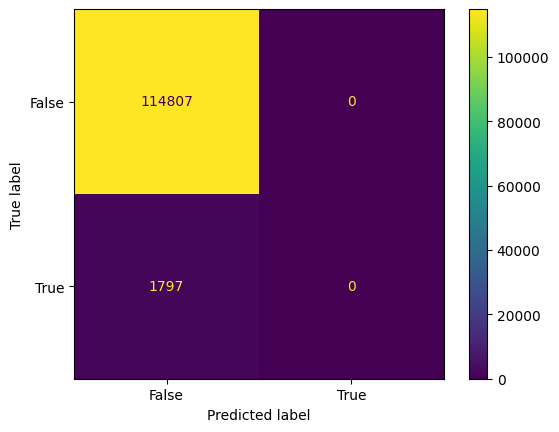

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)